### USE EQNS FROM THE CHINESE PAPER ONLY

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn
import h5py

In [2]:
ncpu = int(mul.cpu_count()*0.75)
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)

param_ranges_NULL = [(1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_lin = [(1e-20, 1e20), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_quad = [(1e-20, 1e15), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]


GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']

grb = 'GRB210619B'
# grb = 'GRB130925A'
grbname = grb + '.txt'
grbname_wtht_ext = grbname.replace('.txt','')


arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m

In [3]:
grb

'GRB210619B'

In [4]:
#MODELS

#NULL model
def nullhp(E, Eb, alpha1, alpha2, mu, zeta):
    
    eob = (E - E0) / (Eb)
    
    return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, Eb, alpha1, alpha2, mu, zeta):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (e0qg * int_z1)/H0 + nullhp(E, Eb, alpha1, alpha2, mu, zeta)

#QUADRATIC model
def quadhp(E, logEqg, Eb, alpha1, alpha2, mu, zeta):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, Eb, alpha1, alpha2, mu, zeta)

In [5]:
#LOG-LIKELIHOODS
def loglike_null(theta):
    Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = nullhp(x,  Eb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_linear(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = linearhp(x, logEqg, Eb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_quad(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = quadhp(x, logEqg, Eb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf    

In [6]:
#PRIORS
Ebmax = 5000 #keV
Ebmin = 0
alpha1min = -3
alpha1max = 10
alpha2min = -10
alpha2max = 3
mumin = 0
mumax = 3
zetamin = 0
zetamax = 4

logeq1min = 0
logeq1max = 20
logeq2min = 0
logeq2max = 15

In [7]:
#PRIOR DISTRIBUTIONS

def prior_transform_null(theta):
    Eb, alpha1, alpha2, mu, zeta = theta
    return [Ebmax * Eb + Ebmin, (alpha1max - alpha1min) * alpha1 + alpha1min, (alpha2max - alpha2min) * alpha2 + alpha2min, (mumax - mumin) * mu + mumin, (zetamax - zetamin) * zeta + zetamin]

def prior_transform_linear(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    return [(logeq1max - logeq1min) * logEqg + logeq1min, Ebmax * Eb + Ebmin, (alpha1max - alpha1min) * alpha1 + alpha1min, (alpha2max - alpha2min) * alpha2 + alpha2min, mumax * mu + mumin, zetamax * zeta + zetamin]

def prior_transform_quadratic(theta):
    logEqg, Eb, alpha1, alpha2, mu, zeta = theta
    return [(logeq2max - logeq2min) * logEqg + logeq2min, Ebmax * Eb + Ebmin, (alpha1max - alpha1min) * alpha1 + alpha1min, (alpha2max - alpha2min) * alpha2 + alpha2min, mumax * mu + mumin, zetamax * zeta + zetamin]

In [8]:
#SAMPLING
nlive = 1024

with dyn.pool.Pool(ncpu, loglike_null, prior_transform_null) as pool0:
    sampler0 = dyn.NestedSampler(loglike_null, prior_transform_null, ndim=5, nlive = nlive, sample='rwalk', bound='multi', pool=pool0)
    sampler0.run_nested(dlogz=0.01)
    # sampler0.save(os.getcwd() + '/outputs/sampler_saves/' + grbname_wtht_ext + '_null_sampler.dill', store_samples=True)

0it [00:00, ?it/s]

398it [00:00, 1909.13it/s, bound: 0 | nc: 3 | ncall: 1524 | eff(%): 26.115 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
931it [00:00, 1437.46it/s, bound: 0 | nc: 1 | ncall: 2545 | eff(%): 36.582 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
1699it [00:01, 686.76it/s, bound: 0 | nc: 16 | ncall: 5544 | eff(%): 30.646 | loglstar:   -inf < -5283.563 <    inf | logz: -5288.911 +/-    nan | dlogz

In [9]:
with dyn.pool.Pool(ncpu, loglike_linear, prior_transform_linear) as pool1:
    sampler1 = dyn.NestedSampler(loglike_linear, prior_transform_linear, ndim=6, nlive = nlive, sample='rwalk', bound='multi', pool=pool1)
    sampler1.run_nested(dlogz=0.01)

/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
559it [00:00, 1706.12it/s, bound: 0 | nc: 4 | ncall: 1797 | eff(%): 31.107 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
731it [00:00, 1502.78it/s, bound: 0 | nc: 3 | ncall: 2155 | eff(%): 33.921 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
1449it [00:01, 854.22it/s, bound: 0 | nc: 9 | ncall: 4422 | eff(%): 32.768 | loglstar:   -inf < -28129.596 <    inf | logz: -28138.642 +/-    nan | dlog

In [10]:
with dyn.pool.Pool(ncpu, loglike_quad, prior_transform_quadratic) as pool2:
    sampler2 = dyn.NestedSampler(loglike_quad, prior_transform_quadratic, ndim=6, nlive = nlive, sample='rwalk', bound='multi', pool=pool2)
    sampler2.run_nested(dlogz=0.01)

/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
771it [00:00, 1576.79it/s, bound: 0 | nc: 3 | ncall: 2199 | eff(%): 35.061 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
1436it [00:01, 942.75it/s, bound: 0 | nc: 6 | ncall: 4201 | eff(%): 34.182 | loglstar:   -inf < -142287.716 <    inf | logz: -142296.750 +/-    nan | dlogz: 143753.948 >  0.010]/tmp/ipykernel_35750/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1

In [11]:
results0 = sampler0.results
results1 = sampler1.results
results2 = sampler2.results

In [12]:
def smooth_plot(results, figname, labels=["logE_qg", "Eb(keV)", "alpha1", "alpha2", "mu", "zeta"]):
        weights = np.exp(results.logwt - results.logz[-1])
        samples = dyn.utils.resample_equal(  results.samples, weights)
        
        fig = corner(samples, weights=weights, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
        ndim =samples.shape[1]
        for axidx, samps in zip([i*(ndim+1) for i in range(ndim)],samples.T):
            kde = gaussian_kde(samps)
            xvals = fig.axes[axidx].get_xlim()
            xvals = np.linspace(xvals[0], xvals[1], 100)
            fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
            
        plt.suptitle(str(grb))
        plt.savefig(os.getcwd() + '/outputs/contours/' + grb + '_' + figname + '.png')
        plt.show()

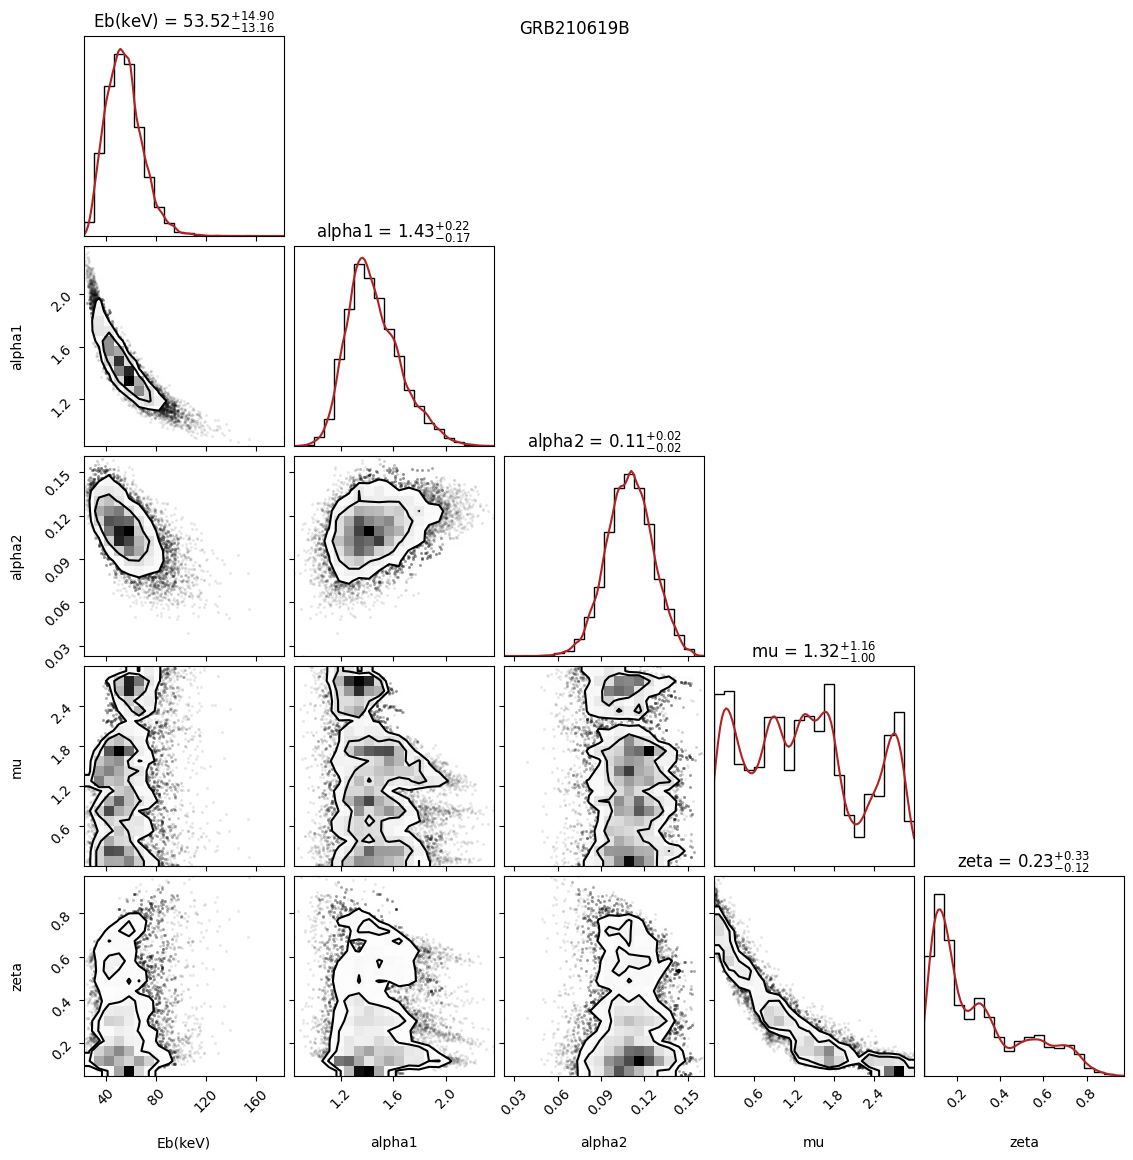

In [13]:
smooth_plot(results0, 'nullhp', labels=["Eb(keV)", "alpha1", "alpha2", "mu", "zeta"])

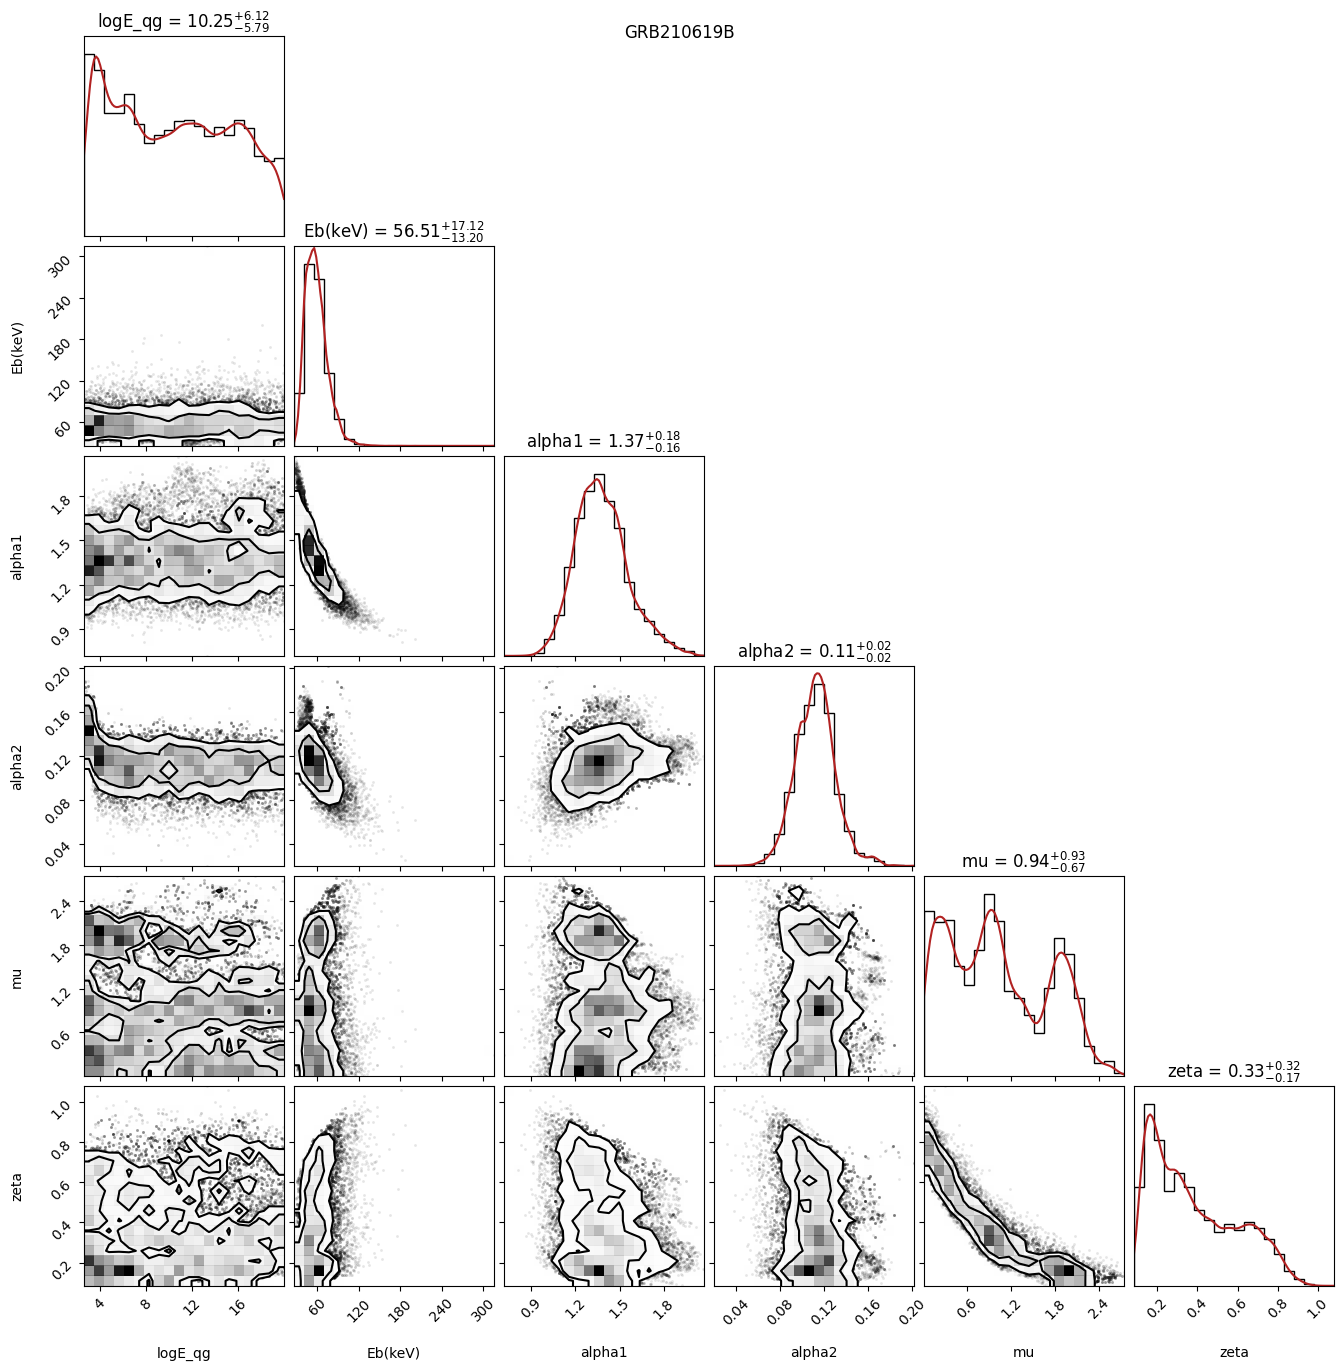

In [14]:
smooth_plot(results1, 'linearhp', labels=["logE_qg", "Eb(keV)", "alpha1", "alpha2", "mu", "zeta"])

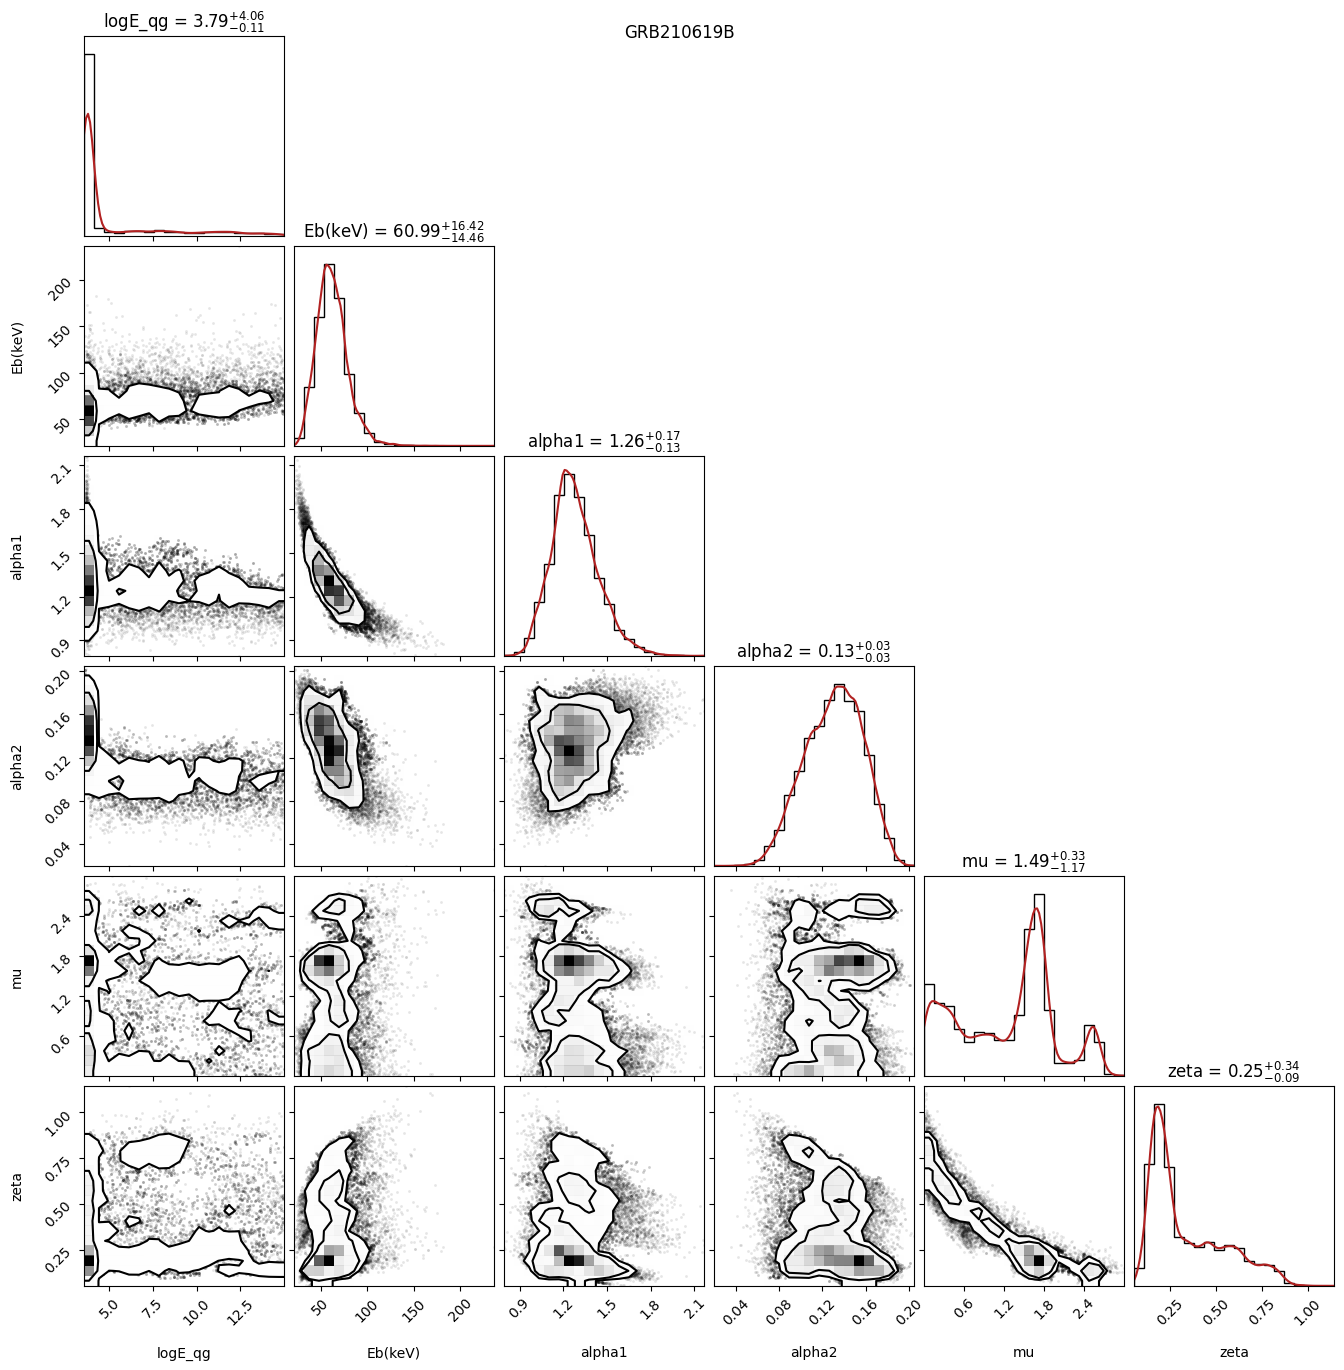

In [15]:
smooth_plot(results2, 'quadhp', labels=["logE_qg", "Eb(keV)", "alpha1", "alpha2", "mu", "zeta"])

In [16]:
results0.samples[np.argmax(results0.logl)]

array([23.56362777,  2.42476697,  0.12514427,  0.63818158,  0.24175389])

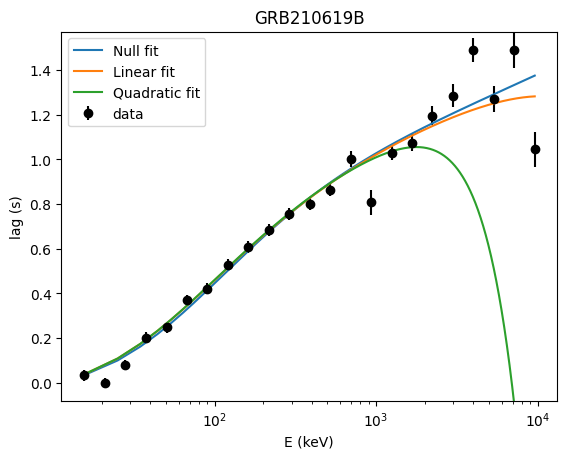

Bayes factor for null model:  -4.112454675054549 +/- 0.14366680302087864
Bayes factor for linear LIV model:  -6.870223105849155 +/- 0.15161202070372984
Bayes factor for quadratic LIV model:  -7.667900835554949 +/- 0.16269354417572038


In [17]:
#PLOTTING FITS

nplot = 1000
E = np.linspace(min(Erest), max(Erest), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
# samples0 = np.median(samples0, axis=0)
samples0 = samples0[np.argmax(results0.logl)]

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
# samples1 = np.median(samples1, axis=0)
samples1 = samples1[np.argmax(results1.logl)]

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
# samples2 = np.median(samples2, axis=0)
samples2 = samples2[np.argmax(results2.logl)]
null_fit = [nullhp(E[i], samples0[0], samples0[1], samples0[2], samples0[3], samples0[4]) for i in range(nplot)]
liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)]
liv_quad_fit = [quadhp(E[i], samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)]

plt.errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
plt.plot(E, null_fit, label='Null fit')
plt.plot(E, liv_lin_fit,label='Linear fit')
plt.plot(E, liv_quad_fit, label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grbname_wtht_ext)
plt.savefig(os.getcwd() + '/outputs/fits/' + grbname_wtht_ext + '_fit_logE.png', facecolor='white')
plt.show()

# bayes_factor_lin = np.exp(results1.logz[-1] - results0.logz[-1])
# bayes_factor_quad = np.exp(results2.logz[-1] - results0.logz[-1])

print('Bayes factor for null model: ', results0.logz[-1], '+/-', results0.logzerr[-1])
print('Bayes factor for linear LIV model: ', results1.logz[-1], '+/-', results1.logzerr[-1])
print('Bayes factor for quadratic LIV model: ', results2.logz[-1], '+/-', results2.logzerr[-1])

with open('outputs/BF/' + grb + '_results.txt', 'w') as f:
    f.write(str(results0.logz[-1]) + ',' + str(results0.logzerr[-1]) + '\n')
    f.write(str(results1.logz[-1]) + ',' + str(results1.logzerr[-1]) + '\n')
    f.write(str(results2.logz[-1]) + ',' + str(results2.logzerr[-1]) + '\n')
    
f.close()
f = []

In [18]:
dyn.utils.save_sampler(sampler0, 'outputs/sampler_saves/' + grb + '_null_sampler.pkl')
dyn.utils.save_sampler(sampler1, 'outputs/sampler_saves/' + grb + '_linear_sampler.pkl')
dyn.utils.save_sampler(sampler2, 'outputs/sampler_saves/' + grb + '_quadratic_sampler.pkl')

In [19]:
def chi2_gof(x, y, yerr, fit_func, *fit_func_args):
    
    return np.sum(((y - fit_func(x, *fit_func_args))/yerr)**2)/(len(y) - len(fit_func_args))

In [20]:
gof_null = chi2_gof(Erest, y, yerr, nullhp, samples0[0], samples0[1], samples0[2], samples0[3], samples0[4])
gof_lin = chi2_gof(Erest, y, yerr, linearhp, samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5])
gof_quad = chi2_gof(Erest, y, yerr, quadhp, samples2[0], samples2[1], samples2[2], samples2[3], samples2[4], samples2[5])


with open('outputs/GOF/' + grb + '_GOF.txt', 'w') as f:
    f.write(str(gof_null) + '\n')
    f.write(str(gof_lin) + '\n')
    f.write(str(gof_quad) + '\n')
    
f.close()
f = []

In [21]:
print('Goodness of fit for null model: ', gof_null)
print('Goodness of fit for linear LIV model: ', gof_lin)
print('Goodness of fit for quadratic LIV model: ', gof_quad)

Goodness of fit for null model:  4.580257908310754
Goodness of fit for linear LIV model:  4.882412062513495
Goodness of fit for quadratic LIV model:  4.719518236236769
